In [1]:
import numpy as np
import pandas as pd
import os
from random import shuffle
import cv2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob as gb
%matplotlib inline


In [2]:
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,Concatenate
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from imutils import paths
from sklearn.model_selection import train_test_split

In [4]:
WIDTH=224
HEIGHT=224

In [5]:
train_image = "dataset/train"
test_image = "dataset/test"


print(train_image)
print(test_image)

dataset/train
dataset/test


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [7]:
from keras import backend as K
def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision
def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall
def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [8]:
#mobilenet model
IMAGE_SIZE=(224,224,3)
mobilenet = MobileNet(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in mobilenet.layers:
    layer.trainable = False

x = mobilenet.output
x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=mobilenet.input, outputs=x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [9]:
opt=Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[precision_threshold(threshold = 0.5), 
                       recall_threshold(threshold = 0.5), 
                       fbeta_score_threshold(beta=0.5, threshold = 0.5),
                      'accuracy','AUC',])
    
train_generator = train_datagen.flow_from_directory(train_image,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_generator = test_datagen.flow_from_directory(test_image,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

start=time.time()
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=30) 
print("training time: %.2f minutes"%((time.time()-start)/60))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
81/81 [==============================] - 300s 4s/step - loss: 1.0200 - precision: 0.8580 - recall: 0.8513 - fbeta_score: 0.8567 - accuracy: 0.8554 - auc: 0.9329 - val_loss: 0.1502 - val_precision: 0.9486 - val_recall: 0.9479 - val_fbeta_score: 0.9485 - val_accuracy: 0.9457 - val_auc: 0.9927
Epoch 2/30
81/81 [==============================] - 218s 3s/step - loss: 0.1656 - precision: 0.9431 - recall: 0.9375 - fbeta_score: 0.9420 - accuracy: 0.9401 - auc: 0.9911 - val_loss: 0.1590 - val_precision: 0.9512 - val_recall: 0.9494 - val_fbeta_score: 0.9509 - val_accuracy: 0.9480 - val_auc: 0.9922
Epoch 3/30
81/81 [==============================] - 217s 3s/step - loss: 0.1525 - precision: 0.9447 - recall: 0.9422 - fbeta_score: 0.9442 - accuracy: 0.9436 - auc: 0.9923 - val_loss: 0.1531 - val_precision: 0.9472 - val_recall: 0.947

Epoch 27/30
81/81 [==============================] - 213s 3s/step - loss: 0.0604 - precision: 0.9779 - recall: 0.9772 - fbeta_score: 0.9778 - accuracy: 0.9780 - auc: 0.9984 - val_loss: 0.1742 - val_precision: 0.9479 - val_recall: 0.9479 - val_fbeta_score: 0.9479 - val_accuracy: 0.9457 - val_auc: 0.9909
Epoch 28/30
81/81 [==============================] - 214s 3s/step - loss: 0.0664 - precision: 0.9744 - recall: 0.9738 - fbeta_score: 0.9743 - accuracy: 0.9743 - auc: 0.9983 - val_loss: 0.1358 - val_precision: 0.9613 - val_recall: 0.9613 - val_fbeta_score: 0.9613 - val_accuracy: 0.9596 - val_auc: 0.9934
Epoch 29/30
81/81 [==============================] - 211s 3s/step - loss: 0.0721 - precision: 0.9713 - recall: 0.9705 - fbeta_score: 0.9711 - accuracy: 0.9706 - auc: 0.9983 - val_loss: 0.1572 - val_precision: 0.9568 - val_recall: 0.9568 - val_fbeta_score: 0.9568 - val_accuracy: 0.9550 - val_auc: 0.9914
Epoch 30/30
81/81 [==============================] - 214s 3s/step - loss: 0.0584 - preci

In [11]:
model.save_weights('mobilenet.h5')

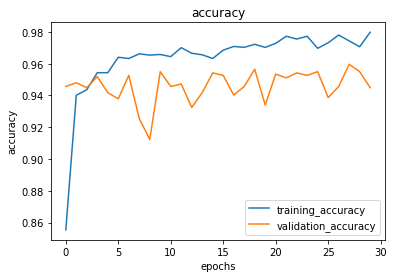

In [12]:
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'],label='training_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.savefig('accuracy_mobilenet.png')

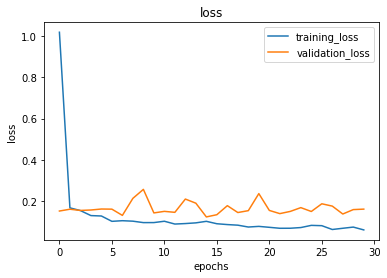

In [13]:
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.savefig('loss_mobilenet.png')

In [14]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)

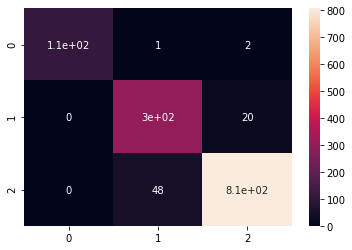

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes,y_pred)
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix_mobilenet.png')

In [16]:
tp=cm[0,0]
fp=cm[0,:].sum()- tp
fn=cm[:,0].sum()- tp
tn=cm.sum().sum()-tp-fp-fn
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1_score=(2*precision*recall)/(precision+recall)
acc=cm.trace()/cm.sum()
print("Test Accuracy :", acc)
print("Test Precision :", precision)
print("Test Recall :", recall)
print("Test F1_Score :", f1_score)

Test Accuracy : 0.9448757763975155
Test Precision : 0.9741379310344828
Test Recall : 1.0
Test F1_Score : 0.9868995633187774


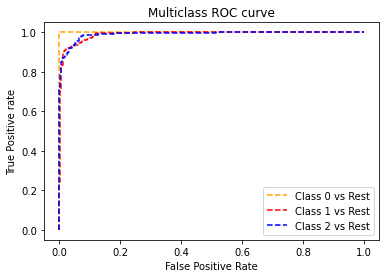

In [17]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_generator.classes, Y_pred[:,i], pos_label=i)
       
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    


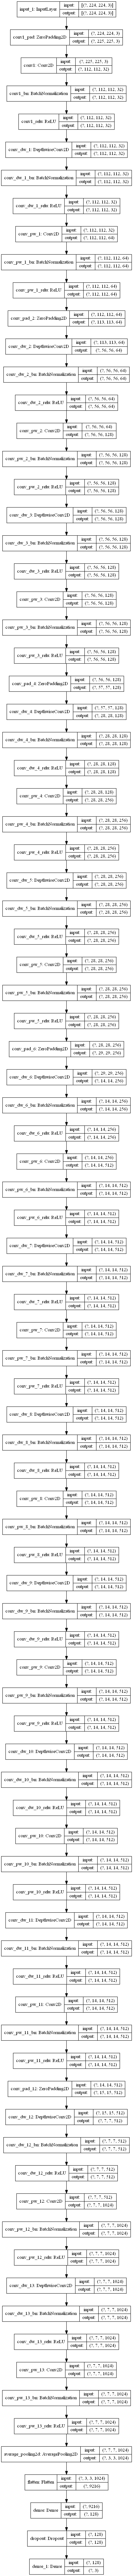

In [19]:
from keras.utils import plot_model
plot_model(model,to_file='mobilenet_model.png',show_shapes=True)